# **Cantoría Evaluation**

Developed by André Paiva

Based on Cantoría Dataset and papers by Helena Cuesta and Emilia Gómez

In [ ]:
import sys
import numpy as np
import pandas as pd
import va_plots
import cantoria_utils

np.set_printoptions(threshold=sys.maxsize)

In [ ]:
mix_df, sop_df, alto_df, ten_df, bass_df = cantoria_utils.cantoria_metrics(5)

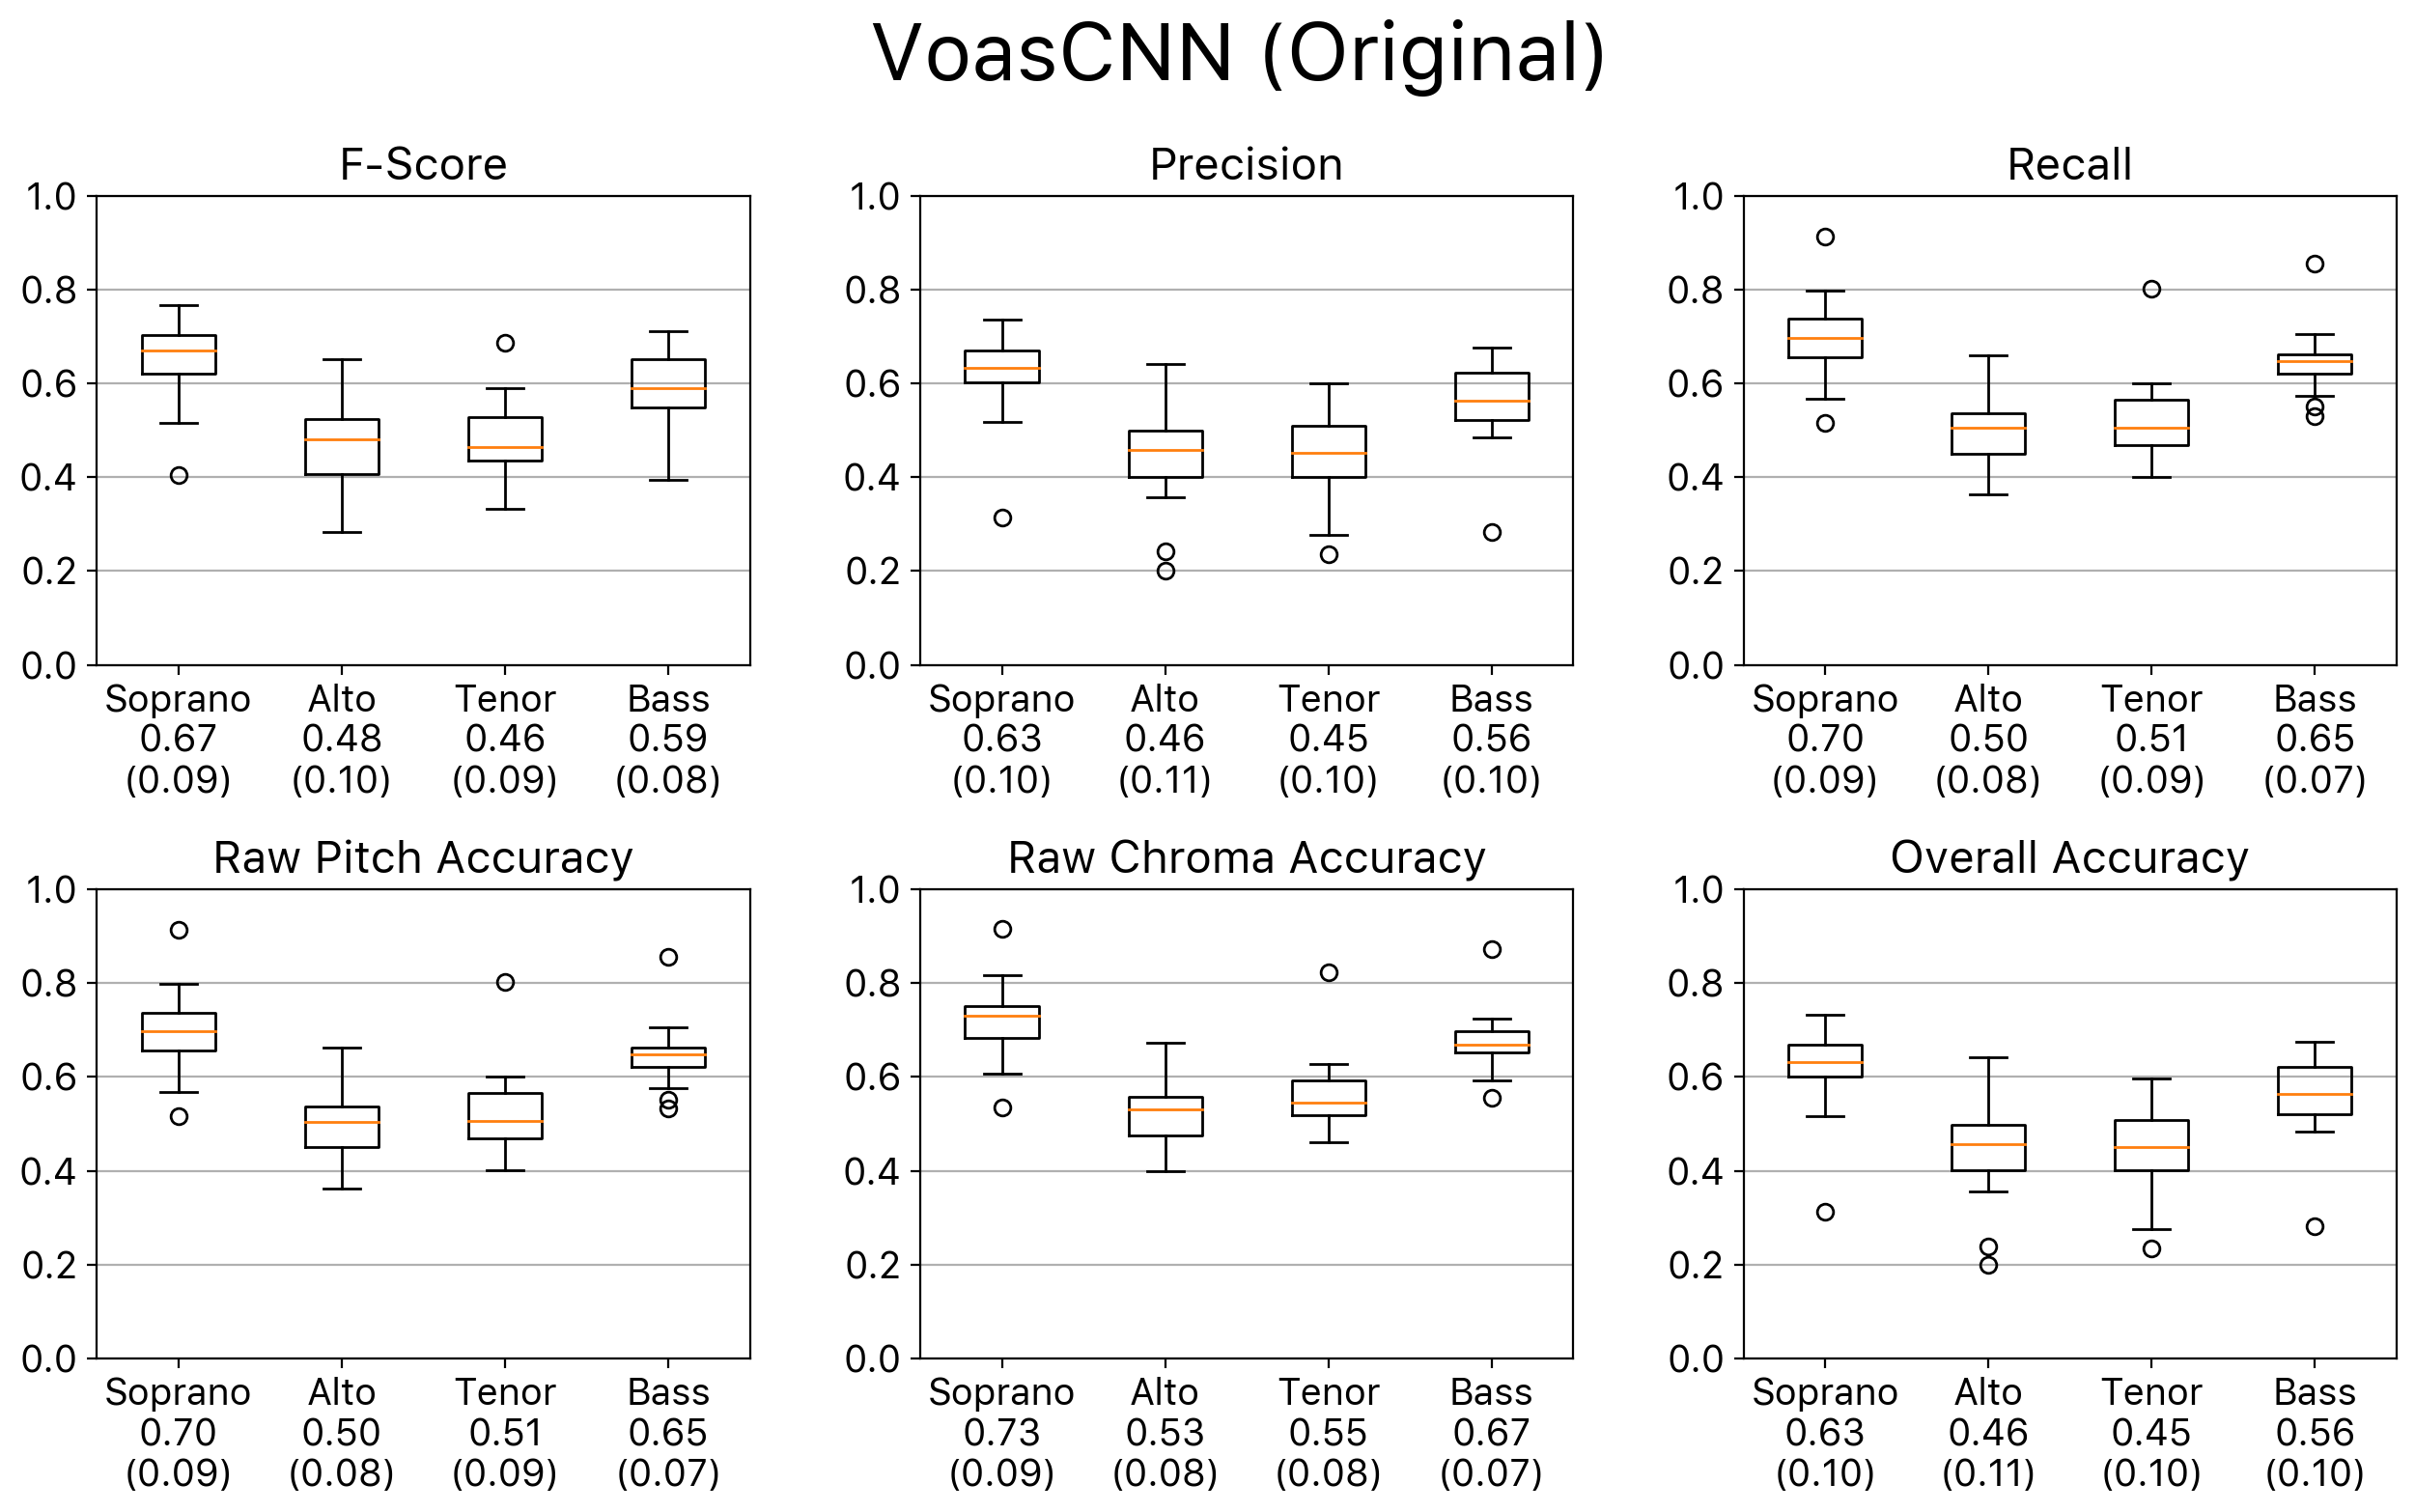

In [3]:
va_plots.evaluation_boxplots(sop_df, alto_df, ten_df, bass_df, 'VoasCNN (Original)')

In [4]:
print(mix_df['Precision'].median(), mix_df['Precision'].std())
print(mix_df['Recall'].median(), mix_df['Recall'].std())
print(mix_df['Accuracy'].median(), mix_df['Accuracy'].std())
print(mix_df['F-Measure'].median(), mix_df['F-Measure'].std())

0.6031117925897801 0.0916854222705166
0.6838760735504519 0.06702031329279569
0.47369932565325745 0.07310039556684801
0.6428226922007954 0.07157328011047664


In [5]:
mix_df

,Songname,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,Chroma Accuracy,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error,F-Measure
0,CEA,0.653420,0.684282,0.502060,0.314179,0.001538,0.048769,0.364487,0.696954,0.729872,0.554042,0.268590,0.001538,0.048769,0.318897,0.668495
0,EJB1,0.599218,0.674704,0.464906,0.323855,0.001441,0.127415,0.452711,0.651434,0.733497,0.526757,0.265061,0.001441,0.127415,0.393918,0.634725
0,EJB2,0.669794,0.722513,0.532749,0.275287,0.002200,0.080909,0.358396,0.708597,0.764369,0.581562,0.233431,0.002200,0.080909,0.316539,0.695155
0,HCB,0.605297,0.843153,0.544038,0.156847,0.000000,0.392957,0.549804,0.621669,0.865959,0.567099,0.134041,0.000000,0.392957,0.526998,0.704695
0,LBM1,0.595664,0.642139,0.447209,0.356534,0.001327,0.079349,0.437210,0.643588,0.693802,0.501223,0.304871,0.001327,0.079349,0.385547,0.618029
0,LBM2,0.637263,0.665177,0.482493,0.333401,0.001423,0.045225,0.380048,0.676909,0.706559,0.528370,0.292018,0.001423,0.045225,0.338666,0.650921
0,LJT1,0.600927,0.626137,0.442245,0.372358,0.001505,0.043458,0.417321,0.657988,0.685593,0.505465,0.312902,0.001505,0.043458,0.357865,0.613273
0,LJT2,0.629431,0.683866,0.487564,0.314565,0.001570,0.088051,0.404186,0.673876,0.732154,0.540603,0.266277,0.001570,0.088051,0.355898,0.655520
0,LNG,0.551245,0.685789,0.440093,0.311373,0.002839,0.246910,0.561121,0.585504,0.728409,0.480588,0.268752,0.002839,0.246910,0.518501,0.611200
0,RRC,0.418212,0.637620,0.337899,0.359881,0.002499,0.527134,0.889514,0.451961,0.689076,0.375404,0.308425,0.002499,0.527134,0.838057,0.505119


In [6]:
sop_df

,Songname,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,...,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error,F-Measure,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy
0,CEA,0.662944,0.689979,0.510792,0.308084,0.001937,0.042716,0.352737,0.698991,0.727495,...,0.270568,0.001937,0.042716,0.315221,0.676191,1.0,1.0,0.690998,0.728515,0.662432
0,EJB1,0.611585,0.661283,0.465700,0.336913,0.001804,0.083064,0.421781,0.640258,0.692285,...,0.305911,0.001804,0.083064,0.390779,0.635464,1.0,1.0,0.661367,0.692453,0.610124
0,EJB2,0.736199,0.798321,0.620749,0.199249,0.002430,0.086812,0.288491,0.752903,0.816435,...,0.181135,0.002430,0.086812,0.270378,0.766002,1.0,1.0,0.798321,0.816435,0.732469
0,HCB,0.625160,0.913268,0.590124,0.086732,0.000000,0.460853,0.547586,0.626765,0.915612,...,0.084388,0.000000,0.460853,0.545241,0.742237,1.0,1.0,0.913268,0.915612,0.622165
0,LBM1,0.581708,0.654625,0.445104,0.343935,0.001440,0.126789,0.472164,0.604234,0.679974,...,0.318586,0.001440,0.126789,0.446815,0.616016,1.0,1.0,0.654625,0.680148,0.580673
0,LBM2,0.633857,0.674990,0.485638,0.323364,0.001646,0.066539,0.391549,0.652409,0.694746,...,0.303608,0.001646,0.066539,0.371793,0.653777,1.0,1.0,0.675081,0.694837,0.632585
0,LJT1,0.599139,0.611034,0.433721,0.387186,0.001780,0.021633,0.410599,0.640090,0.652798,...,0.345422,0.001780,0.021633,0.368835,0.605028,1.0,1.0,0.611074,0.653035,0.597972
0,LJT2,0.689518,0.716304,0.541611,0.281695,0.002001,0.040848,0.324544,0.706006,0.733431,...,0.264567,0.002001,0.040848,0.307416,0.702656,1.0,1.0,0.716304,0.733431,0.687804
0,LNG,0.631752,0.703722,0.499023,0.293877,0.002401,0.116322,0.412600,0.659206,0.734303,...,0.263295,0.002401,0.116322,0.382019,0.665798,1.0,1.0,0.704146,0.734798,0.629817
0,RRC,0.313601,0.567878,0.253183,0.429896,0.002226,0.813056,1.245178,0.335313,0.607196,...,0.390579,0.002226,0.813056,1.205861,0.404064,1.0,1.0,0.567878,0.607196,0.312194


In [7]:
alto_df

,Songname,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,...,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error,F-Measure,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy
0,CEA,0.516812,0.534144,0.356240,0.463425,0.002432,0.035968,0.501824,0.534163,0.552077,...,0.445491,0.002432,0.035968,0.483891,0.525335,1.0,1.0,0.535056,0.552989,0.516126
0,EJB1,0.457790,0.497195,0.312921,0.500527,0.002277,0.088356,0.591160,0.483885,0.525537,...,0.472186,0.002277,0.088356,0.562819,0.476679,1.0,1.0,0.497195,0.525579,0.456248
0,EJB2,0.580810,0.624917,0.430674,0.372001,0.003082,0.079023,0.454105,0.596768,0.642087,...,0.354832,0.003082,0.079023,0.436936,0.602057,1.0,1.0,0.624917,0.642087,0.575395
0,HCB,0.460277,0.630952,0.362646,0.369048,0.000000,0.370811,0.739859,0.460277,0.630952,...,0.369048,0.000000,0.370811,0.739859,0.532267,1.0,1.0,0.630952,0.630952,0.457042
0,LBM1,0.398635,0.411219,0.253784,0.586741,0.002040,0.033608,0.622389,0.437808,0.451628,...,0.546331,0.002040,0.033608,0.581980,0.404829,1.0,1.0,0.411379,0.452068,0.397926
0,LBM2,0.482151,0.491785,0.321807,0.506156,0.002059,0.022039,0.530255,0.508570,0.518731,...,0.479210,0.002059,0.022039,0.503308,0.486920,1.0,1.0,0.491785,0.518819,0.480974
0,LJT1,0.356494,0.362843,0.219245,0.635183,0.001974,0.019783,0.656940,0.392730,0.399724,...,0.598302,0.001974,0.019783,0.620059,0.359641,1.0,1.0,0.362843,0.400079,0.355625
0,LJT2,0.504877,0.536940,0.351730,0.461130,0.001930,0.065436,0.528496,0.525802,0.559194,...,0.438876,0.001930,0.065436,0.506242,0.520415,1.0,1.0,0.536940,0.559194,0.503165
0,LNG,0.408249,0.522962,0.297471,0.472974,0.004064,0.285052,0.762091,0.426840,0.546777,...,0.449159,0.004064,0.285052,0.738275,0.458540,1.0,1.0,0.523775,0.547671,0.407075
0,RRC,0.241125,0.441729,0.184807,0.555263,0.003008,0.834962,1.393233,0.250770,0.459398,...,0.537594,0.003008,0.834962,1.375564,0.311961,1.0,1.0,0.441729,0.461654,0.239600


In [8]:
ten_df

,Songname,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,...,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error,F-Measure,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy
0,CEA,0.522956,0.565291,0.372967,0.433757,0.000952,0.081905,0.516614,0.551444,0.596085,...,0.402963,0.000952,0.081905,0.485820,0.543300,1.0,1.0,0.565820,0.596614,0.522576
0,EJB1,0.413462,0.449711,0.274555,0.548855,0.001434,0.089107,0.639396,0.469836,0.511028,...,0.487538,0.001434,0.089107,0.578080,0.430825,1.0,1.0,0.449880,0.511449,0.412864
0,EJB2,0.549614,0.599202,0.401873,0.399246,0.001552,0.091776,0.492574,0.574014,0.625804,...,0.372645,0.001552,0.091776,0.465972,0.573338,1.0,1.0,0.600310,0.626912,0.548845
0,HCB,0.600128,0.801887,0.522638,0.198113,0.000000,0.336192,0.534305,0.616175,0.823328,...,0.176672,0.000000,0.336192,0.512864,0.686490,1.0,1.0,0.801887,0.823328,0.597253
0,LBM1,0.432924,0.462964,0.288195,0.535959,0.001078,0.070466,0.607503,0.478197,0.511378,...,0.487544,0.001078,0.070466,0.559088,0.447440,1.0,1.0,0.463254,0.511668,0.432524
0,LBM2,0.467619,0.493233,0.315863,0.505591,0.001177,0.055950,0.562718,0.508219,0.536055,...,0.462768,0.001177,0.055950,0.519895,0.480085,1.0,1.0,0.493504,0.536327,0.467175
0,LJT1,0.378634,0.400361,0.241615,0.598287,0.001353,0.058734,0.658374,0.435189,0.460161,...,0.538487,0.001353,0.058734,0.598574,0.389194,1.0,1.0,0.400689,0.460530,0.378343
0,LJT2,0.465202,0.488145,0.312678,0.510072,0.001783,0.051102,0.562957,0.518602,0.544180,...,0.454038,0.001783,0.051102,0.506923,0.476398,1.0,1.0,0.488502,0.544596,0.464621
0,LNG,0.396770,0.527313,0.292675,0.470162,0.002525,0.331538,0.804225,0.427359,0.567966,...,0.429509,0.002525,0.331538,0.763572,0.452821,1.0,1.0,0.527986,0.568976,0.396273
0,RRC,0.276618,0.507895,0.218150,0.490226,0.001880,0.837970,1.330075,0.297297,0.545865,...,0.452256,0.001880,0.837970,1.292105,0.358165,1.0,1.0,0.507895,0.545865,0.275489


In [9]:
bass_df

,Songname,Precision,Recall,Accuracy,Substitution Error,Miss Error,False Alarm Error,Total Error,Chroma Precision,Chroma Recall,...,Chroma Substitution Error,Chroma Miss Error,Chroma False Alarm Error,Chroma Total Error,F-Measure,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy
0,CEA,0.554566,0.574005,0.392872,0.424780,0.001216,0.036268,0.462263,0.592933,0.613717,...,0.385067,0.001216,0.036268,0.422551,0.564118,1.0,1.0,0.575018,0.614730,0.554730
0,EJB1,0.518164,0.657921,0.408191,0.341341,0.000738,0.270454,0.612533,0.550382,0.698828,...,0.300433,0.000738,0.270454,0.571625,0.579738,1.0,1.0,0.658019,0.698927,0.517319
0,EJB2,0.661425,0.704130,0.517578,0.293913,0.001957,0.066522,0.362391,0.678375,0.722174,...,0.275870,0.001957,0.066522,0.344348,0.682110,1.0,1.0,0.705217,0.723261,0.657479
0,HCB,0.607246,0.856239,0.551062,0.143761,0.000000,0.410036,0.553797,0.618788,0.872514,...,0.127486,0.000000,0.410036,0.537523,0.710561,1.0,1.0,0.856239,0.872514,0.604919
0,LBM1,0.573133,0.624741,0.426356,0.374245,0.001014,0.091059,0.466318,0.601573,0.655742,...,0.343244,0.001014,0.091059,0.435317,0.597826,1.0,1.0,0.624952,0.655995,0.572661
0,LBM2,0.628212,0.651263,0.470080,0.347758,0.000978,0.037671,0.386408,0.648805,0.672612,...,0.326410,0.000978,0.037671,0.365060,0.639530,1.0,1.0,0.651752,0.673101,0.627957
0,LJT1,0.512244,0.550673,0.361252,0.448369,0.000958,0.075978,0.525305,0.549985,0.591244,...,0.407798,0.000958,0.075978,0.484734,0.530764,1.0,1.0,0.550881,0.591661,0.511823
0,LJT2,0.529951,0.641755,0.408966,0.357491,0.000754,0.211724,0.569969,0.550957,0.667192,...,0.332053,0.000754,0.211724,0.544532,0.580519,1.0,1.0,0.641755,0.667192,0.528993
0,LNG,0.485240,0.618540,0.373476,0.378957,0.002503,0.277213,0.658672,0.509692,0.649709,...,0.347787,0.002503,0.277213,0.627503,0.543841,1.0,1.0,0.618702,0.650032,0.484018
0,RRC,0.650092,0.663118,0.488694,0.333960,0.002922,0.022960,0.359841,0.676898,0.690461,...,0.306617,0.002922,0.022960,0.332498,0.656541,1.0,1.0,0.664371,0.692131,0.649062
